# Chapter 4 - Markov Chains and Networks (Python Code)

We begin with some imports.

In [1]:
import quantecon as qe
import quantecon_book_networks.input_output as qbn_io
import quantecon_book_networks.plotting as qbn_plt
import quantecon_book_networks.data as qbn_data
ch4_data = qbn_data.markov_chains_and_networks()

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Example transition matrices

In this chapter two transition matrices are used.

First, a Markov model is estimated in the international growth dynamics study of [Quah (1993)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.142.5504&rep=rep1&type=pdf). The state is real GDP per capita in a given country relative to the world average. Quah discretizes the possible values to 0–1/4, 1/4–1/2, 1/2–1, 1–2 and 2–inf, calling these states 1 to 5 respectively. The transitions are over a one year period.

In [3]:
P_Q = [
    [0.97, 0.03, 0,    0,    0   ],
    [0.05, 0.92, 0.03, 0,    0   ],
    [0,    0.04, 0.92, 0.04, 0   ],
    [0,    0,    0.04, 0.94, 0.02],
    [0,    0,    0,    0.01, 0.99]
]
P_Q = np.array(P_Q)
codes_Q =  ( '1','2','3','4','5')

Second, [Benhabib et al. (2015)](https://www.economicdynamics.org/meetpapers/2015/paper_364.pdf) estimate the following transition matrix for intergenerational social mobility. The states are percentiles of the wealth distribution, in particular, the codes 1, 2,… , 8, correspond to the percentiles 0–20%, 20–40%, 40–60%, 60–80%, 80–90%, 90–95%, 95–99%, 99–100%.

In [4]:
P_B = [
    [0.222, 0.222, 0.215, 0.187, 0.081, 0.038, 0.029, 0.006],
    [0.221, 0.22,  0.215, 0.188, 0.082, 0.039, 0.029, 0.006],
    [0.207, 0.209, 0.21,  0.194, 0.09,  0.046, 0.036, 0.008],
    [0.198, 0.201, 0.207, 0.198, 0.095, 0.052, 0.04,  0.009],
    [0.175, 0.178, 0.197, 0.207, 0.11,  0.067, 0.054, 0.012],
    [0.182, 0.184, 0.2,   0.205, 0.106, 0.062, 0.05,  0.011],
    [0.123, 0.125, 0.166, 0.216, 0.141, 0.114, 0.094, 0.021],
    [0.084, 0.084, 0.142, 0.228, 0.17,  0.143, 0.121, 0.028]
    ]

P_B = np.array(P_B)
codes_B =  ( '1','2','3','4','5','6','7','8')

## Markov Chains as Digraphs

### Contour plot of transition matrix $P_B$

Here we define a function for producing contour plots of matrices.

In [5]:
def plot_matrices(matrix,
                  codes,
                  ax,
                  font_size=12,
                  alpha=0.6, 
                  colormap=cm.viridis, 
                  color45d=None, 
                  xlabel='sector $j$', 
                  ylabel='sector $i$'):
    
    ticks = range(len(matrix))

    levels = np.sqrt(np.linspace(0, 0.75, 100))
    
    
    if color45d != None:
        co = ax.contourf(ticks, 
                         ticks,
                         matrix,
                         alpha=alpha, cmap=colormap)
        ax.plot(ticks, ticks, color=color45d)
    else:
        co = ax.contourf(ticks, 
                         ticks,
                         matrix,
                         levels,
                         alpha=alpha, cmap=colormap)

    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    ax.set_yticks(ticks)
    ax.set_yticklabels(codes_B)
    ax.set_xticks(ticks)
    ax.set_xticklabels(codes_B)


Now we use our function to produce a plot of the transition matrix for intergenerational social mobility, $P_B$.

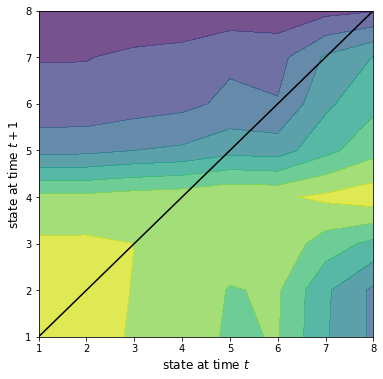

In [6]:
fig, ax = plt.subplots(figsize=(6,6))
plot_matrices(P_B.transpose(), codes_B, ax, alpha=0.75, 
                 colormap=cm.viridis, color45d='black',
                 xlabel='state at time $t$', ylabel='state at time $t+1$')

plt.show()

### Wealth percentile over time

Here, we compare the mixing of the transition matrix for intergenerational social mobility $P_B$ and the transition matrix for international growth dynamics $P_Q$. 

We begin by creating quantecon MarkovChain objects with each of our transition matrices.

In [7]:
mc_B = qe.MarkovChain(P_B, state_values=range(1, 9))
mc_Q = qe.MarkovChain(P_Q, state_values=range(1, 6))

Next we define a function to plot simultations of Markov processes. Two simulations will be run for each MarkovChain, one starting at the minimum initial value and one at the maximum.

In [8]:
def sim_fig(ax, mc, T=100, seed=14, title=None):
    X1 = mc.simulate(T, init=1, random_state=seed)
    X2 = mc.simulate(T, init=max(mc.state_values), random_state=seed+1)
    ax.plot(X1, label="low initial state")
    ax.plot(X2, label="high initial state")
    ax.set_title(title, fontsize=12)

Finally, we produce the figure.

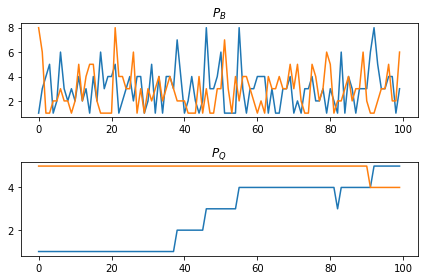

In [9]:
fig, axes = plt.subplots(2, 1)
sim_fig(axes[0], mc_B, title="$P_B$")
sim_fig(axes[1], mc_Q, title="$P_Q$")

plt.tight_layout()
plt.show()

### Predicted vs realized cross-country income distributions for 2019

Here we load a pandas dataframe of GDP per capita data for countries compared to the global average.

In [10]:
gdppc_df = ch4_data['gdppc_df']
gdppc_df.head()

,,gdppc,gdppc_w,gdppc_r
country,year,,,
Aruba,2019,NaN,11397.086,NaN
Afghanistan,2019,494.179350,11397.086,0.043360
Angola,2019,2809.626088,11397.086,0.246521
Albania,2019,5395.659532,11397.086,0.473424
Andorra,2019,40897.330873,11397.086,3.588402


Now we assign countries bins as per Quah (1993).

In [11]:
q = [0, 0.25, 0.5, 1.0, 2.0, np.inf]
l = [0, 1, 2, 3, 4]

x = pd.cut(gdppc_df.gdppc_r, bins=q, labels=l)
gdppc_df['interval'] = x

gdppc_df = gdppc_df.reset_index()
gdppc_df['interval'] = gdppc_df['interval'].astype(float)
gdppc_df['year'] = gdppc_df['year'].astype(float)

Here we define a function for calculating the cross-country income distributions for a given date range.

In [12]:
def gdp_dist_estimate(df, l, yr=(1960, 2019)):
    Y = np.zeros(len(l))
    for i in l:
        Y[i] = df[
            (df['interval'] == i) & 
            (df['year'] <= yr[1]) & 
            (df['year'] >= yr[0])
            ].count()[0]
    
    return Y / Y.sum()

We calculate the true distribution for 1985.

In [13]:
ψ_1985 = gdp_dist_estimate(gdppc_df,l,yr=(1985, 1985))

Now, we use the transition matrix to update the 1985 distribution 𝑡 = 2019 − 1985 = 34 times to get our predicted 2019 distribution.

In [14]:
ψ_2019_predicted = ψ_1985 @ np.linalg.matrix_power(P_Q, 2019-1985)

Now, calculate the true 2019 distribution.

In [15]:
ψ_2019 = gdp_dist_estimate(gdppc_df,l,yr=(2019, 2019))

Finally we produce the plot.

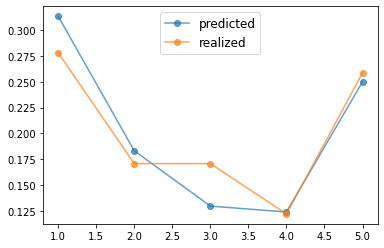

In [16]:
states = np.arange(1, 6)

fig, ax = plt.subplots()
width = 0.4
ax.plot(states, ψ_2019_predicted, '-o', alpha=0.7, label='predicted')
ax.plot(states, ψ_2019, '-o', alpha=0.7, label='realized')

ax.legend(loc='upper center', fontsize=12)
plt.show()


### Distribution dynamics

Here we define a function for plotting the convergence of marginal distributions $ψ$ under a transition matrix $P$ on the unit simplex.

In [17]:
def convergence_plot(ψ, P, n=14, angle=50):

    ax = qbn_plt.unit_simplex(angle)

    # Convergence plot
    
    P = np.array(P)

    ψ = ψ        # Initial condition

    x_vals, y_vals, z_vals = [], [], []
    for t in range(n):
        x_vals.append(ψ[0])
        y_vals.append(ψ[1])
        z_vals.append(ψ[2])
        ψ = ψ @ P

    ax.scatter(x_vals, y_vals, z_vals, c='darkred', s=80, alpha=0.7, depthshade=False)

    mc = qe.MarkovChain(P)
    ψ_star = mc.stationary_distributions[0]
    ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='k', s=80)

    return ψ


Now we define P.

In [18]:
P = (
    (0.9, 0.1, 0.0),
    (0.4, 0.4, 0.2),
    (0.1, 0.1, 0.8)
    )

#### A trajectory from $\psi_0 = (0, 0, 1)$

Here we see the sequence of marginals appears to converge.

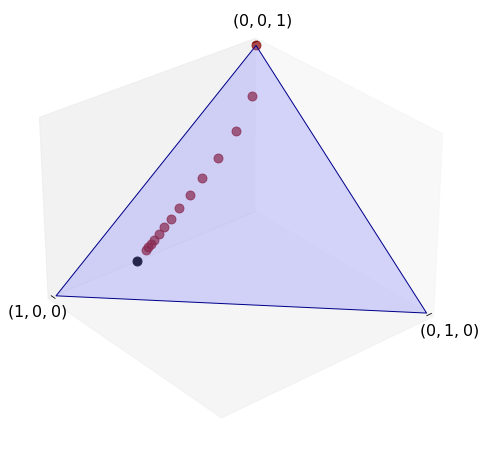

In [19]:
ψ_0 = (0, 0, 1)
ψ = convergence_plot(ψ_0, P)
plt.show()

#### A trajectory from $\psi_0 = (0, 1/2, 1/2)$

Here we see again that the sequence of marginals appears to converge, and the limit appears not to depend on the initial distribution.

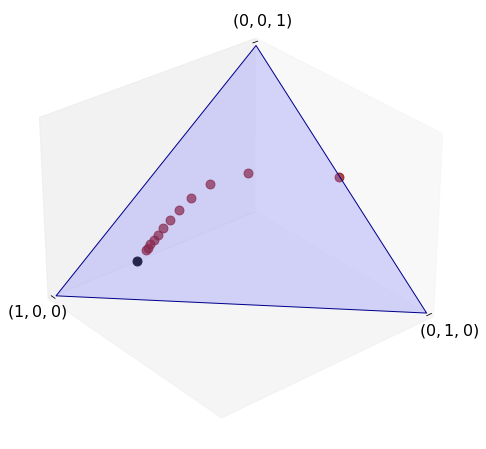

In [20]:
ψ_0 = (0, 1/2, 1/2)
ψ = convergence_plot(ψ_0, P, n=12)
plt.show()

### Distribution projections from $P_B$

Here we define a function for plotting $\psi$ after $n$ iterations of the transition matrix $P$. $\psi_0$ is taken as the unifrom distribution over the state space.

In [21]:
def transition(P, n, ax=None):
    
    P = np.array(P)
    nstates = P.shape[1]
    s0 = np.ones(8) * 1/nstates
    s = s0
    
    for i in range(n):
        s = s @ P
        
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.plot(range(1, nstates+1), s, '-o', alpha=0.6)
    ax.set(ylim=(0, 0.25), 
           xticks=((1, nstates)))
    ax.set_title(f"t = {n}")
    
    return ax

We now generate the marginal distributions after 0, 1, 2, and 100 iterations for $P_B$.

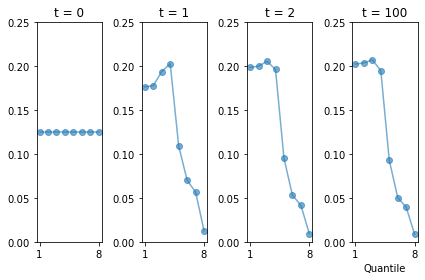

In [22]:
ns = (0, 1, 2, 100)
fig, axes = plt.subplots(1, len(ns))

for n, ax in zip(ns, axes):
    ax = transition(P_B, n, ax=ax)
    
axes[-1].set_xlabel("Quantile")

plt.tight_layout()
plt.show()

## Asymptotics

### Convergence of the empirical distribution to $\psi^*$

We begin by creating a Markov Chain object, taking $P_B$ as the transition matrix.

In [23]:
mc = qe.MarkovChain(P_B)

Next we use the quantecon package to calculate the true stationary distribution.

In [24]:
stationary = mc.stationary_distributions[0]
n = len(mc.P)

Now we define a function simulate the Markov chain.

In [25]:
def simulate_distribution(mc, T=100):
    # Simulate path 
    n = len(mc.P)
    path = mc.simulate_indices(ts_length=T, random_state=1)
    distribution = np.empty(n)
    for i in range(n):
        distribution[i] = np.mean(path==i)
    return distribution


We run simulations of length 10, 100, 1,000 and 10,000.

In [26]:
lengths = [10, 100, 1_000, 10_000]
dists = []

for t in lengths:
    dists.append(simulate_distribution(mc, t))

Now we produce the plots. We see that the simulated distribution starts to aproach the true stationary distribution.

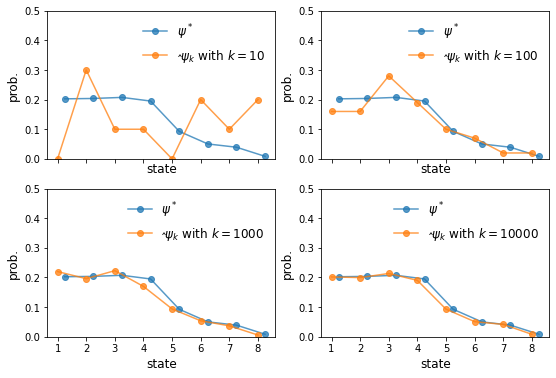

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6), sharex='all')#, sharey='all')

axes = axes.flatten()

for dist, ax, t in zip(dists, axes, lengths):
    
    ax.plot(np.arange(n)+1 + .25, 
           stationary, 
            '-o',
           #width = 0.25, 
           label='$\\psi^*$', 
           alpha=0.75)
    
    ax.plot(np.arange(n)+1, 
           dist, 
            '-o',
           #width = 0.25, 
           label=f'$\\hat \\psi_k$ with $k={t}$', 
           alpha=0.75)


    ax.set_xlabel("state", fontsize=12)
    ax.set_ylabel("prob.", fontsize=12)
    ax.set_xticks(np.arange(n)+1)
    ax.legend(loc='upper right', fontsize=12, frameon=False)
    ax.set_ylim(0, 0.5)
    
plt.show()